<a href="https://colab.research.google.com/github/AnIsAsPe/Regresion-Robusta-para-estimar-tiempo-de-respuesta-de-un-servicio-de-emergencia/blob/main/1_Response_time_Paris_Fire_Brigade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bibiliotecas

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics

import matplotlib.pyplot as plt 
import seaborn as sns  

## Definición de funciones

In [2]:
def correlacion(dataframe, grafica=True, matrix=False, tamaño =(12,8)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()                   
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm", 
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(), 
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [3]:
def describe_datos(df):
  unicos =[]
  for col in df:
    unicos.append(df[col].unique())
  unicos = pd.Series(unicos, index=df.columns)
  descripcion = pd.concat([df.dtypes, len(df)-df.isna().sum(),df.nunique(),unicos], axis=1)
  descripcion.columns = ['dtypes', 'not-null','nunique','unique' ]
  return(descripcion)

# Lectura datos y selección de características

__Cargar etiquetas__

In [4]:
# Variables respuesta
Ys = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/y_train.csv', 
                     index_col=[0], sep=',')
print(Ys.shape)
Ys.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [5]:
# Se puede verificar si la última columna es la suma de las otras dos
(Ys.iloc[:,0] + Ys.iloc[:,1] == Ys.iloc[:,2]).sum()==len(Ys)

True

Nos vamos a concentrar en el tiempo desde la salida del vehículo hasta la presentación en el lugar del siniestro

In [6]:
Y = Ys['delta departure-presentation']
Y.describe()

count    219337.000000
mean        356.161026
std         228.381939
min           1.000000
25%         231.000000
50%         319.000000
75%         434.000000
max       22722.000000
Name: delta departure-presentation, dtype: float64

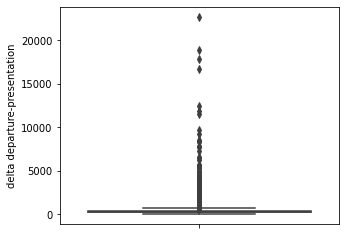

In [7]:
plt.figure(figsize=(5,4))
sns.boxplot(y=Y, showfliers=True)

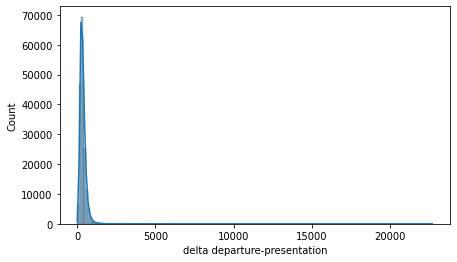

In [8]:
plt.figure(figsize=(7,4))
sns.histplot(Y, bins=200,  kde=True )
plt.show()

__Cargar características__

In [9]:
# Conjunto de caracteristicas (X)
X = pd.read_csv('drive/My Drive/Datos/ParisFireBrigade/x_train.csv', 
                sep=',', index_col=[0], parse_dates=['selection time'] )
print(X.shape)
X.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,rescue center,selection time,date key sélection,time key sélection,status preceding selection,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,2447,2018-07-08 19:02:43.990,20180708,190243,Rentré,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,2464,2018-01-04 09:02:59.470,20180104,90259,Rentré,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [10]:
describe_datos(X)

,dtypes,not-null,nunique,unique
intervention,int64,219337,200894,"[13264186, 12663715, 13675521, 12695745, 13698..."
alert reason category,int64,219337,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
alert reason,int64,219337,126,"[2162, 2124, 2163, 2112, 2711, 2113, 2135, 212..."
intervention on public roads,int64,219337,2,"[0, 1]"
floor,int64,219337,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,float64,206627,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,219337,83484,"[2.284796, 2.247464, 2.2583279999999997, 2.393..."
latitude intervention,float64,219337,74503,"[48.879669, 48.818191, 48.836759, 48.776526000..."
emergency vehicle,int64,219337,749,"[4511, 4327, 4509, 5731, 5623, 4319, 4215, 588..."
emergency vehicle type,object,219337,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


existen más de una selección de veículos por intervensión, el análisis lo vamos a hacer por vehículo

In [11]:
#Borrar columnas que no utilizaremos

col_borrar=['intervention',  #identificador de la intervención
            'emergency vehicle',  #id 749 vehículo de emergencia, que están agrupada en 'emergency vehicle type'
            'alert reason', # 126 categorías, que están resumidas en 'alert reason category'
            
            # Variables geográficas
            'OSRM response', #rutas
            'GPS tracks departure-presentation', #rutas
            'GPS tracks datetime departure-presentation', #rutas
            'longitude intervention', 'latitude intervention', #coordenadas
            'longitude before departure',  #coordenadas
            'latitude before departure',    #coordenadas

            # Redundantes
            'date key sélection', 'time key sélection', # redundantes con 'selection time'

            #variable no relaccionadas con delta departure-presentation
            'status preceding selection',  
            'rescue center', # id 94 centros de rescate, estacionamiento de los vehícuos
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'delta position gps previous departure-departure'
            ]
X = X.drop(columns= col_borrar)

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219337 entries, 5105452 to 4868867
Data columns (total 8 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   alert reason category         219337 non-null  int64         
 1   intervention on public roads  219337 non-null  int64         
 2   floor                         219337 non-null  int64         
 3   location of the event         206627 non-null  float64       
 4   emergency vehicle type        219337 non-null  object        
 5   selection time                219337 non-null  datetime64[ns]
 6   OSRM estimated distance       219337 non-null  float64       
 7   OSRM estimated duration       219337 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 15.1+ MB


__Unir caracteristicas con étiquetas__

In [12]:
df=pd.concat([X,Y], axis=1)
print(df.shape)
df.head(2)

(219337, 9)


,alert reason category,intervention on public roads,floor,location of the event,emergency vehicle type,selection time,OSRM estimated distance,OSRM estimated duration,delta departure-presentation
emergency vehicle selection,,,,,,,,,
5105452,3,0,0,148.0,VSAV BSPP,2018-07-08 19:02:43.990,952.5,105.8,324
4720915,3,0,1,136.0,PSE,2018-01-04 09:02:59.470,2238.5,243.2,297


# Idetificación del tipo de variable de cada columna

Comparamos el tipo de cada columna con la documentación de los parámetros de entrada en [la documentación provista por el Challenge](https://paris-fire-brigade.github.io/data-challenge/challenge.html)

In [13]:
df.dtypes

alert reason category                    int64
intervention on public roads             int64
floor                                    int64
location of the event                  float64
emergency vehicle type                  object
selection time                  datetime64[ns]
OSRM estimated distance                float64
OSRM estimated duration                float64
delta departure-presentation             int64
dtype: object

In [14]:
categoricas=['alert reason category','location of the event',
             'emergency vehicle type']
df[categoricas] = df[categoricas].astype('object')

df['intervention on public roads']=df['intervention on public roads'].astype('bool')
describe_datos(df)

,dtypes,not-null,nunique,unique
alert reason category,object,219337,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,bool,219337,2,"[False, True]"
floor,int64,219337,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,206627,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,219337,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
selection time,datetime64[ns],219337,219285,"[2018-07-08T19:02:43.990000000, 2018-01-04T09:..."
OSRM estimated distance,float64,219337,48461,"[952.5, 2238.5, 3026.4, 1934.2, 2706.7, 1685.8..."
OSRM estimated duration,float64,219337,8236,"[105.8, 243.2, 295.4, 166.6, 262.6, 187.7, 301..."
delta departure-presentation,int64,219337,1909,"[324, 297, 365, 160, 523, 419, 452, 404, 411, ..."


# Manejo de Valores Nulos

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219337 entries, 5105452 to 4868867
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   alert reason category         219337 non-null  object        
 1   intervention on public roads  219337 non-null  bool          
 2   floor                         219337 non-null  int64         
 3   location of the event         206627 non-null  object        
 4   emergency vehicle type        219337 non-null  object        
 5   selection time                219337 non-null  datetime64[ns]
 6   OSRM estimated distance       219337 non-null  float64       
 7   OSRM estimated duration       219337 non-null  float64       
 8   delta departure-presentation  219337 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 15.3+ MB


In [16]:
df.isna().sum()/len(df)*100  # porcentaje de valores nulos

alert reason category           0.000000
intervention on public roads    0.000000
floor                           0.000000
location of the event           5.794736
emergency vehicle type          0.000000
selection time                  0.000000
OSRM estimated distance         0.000000
OSRM estimated duration         0.000000
delta departure-presentation    0.000000
dtype: float64

In [17]:
df['location of the event'].value_counts(dropna=False)/len(df)*100

139.0    23.266024
136.0    20.242823
148.0    14.588054
NaN       5.794736
149.0     4.515882
           ...    
284.0     0.000456
324.0     0.000456
213.0     0.000456
215.0     0.000456
265.0     0.000456
Name: location of the event, Length: 211, dtype: float64


**Alternativas**
- Borrar esos renglones, 
- borrar esa variable, 
- imputar valores:
   - ¿remplazar por ceros?
   - ¿reemplazar por una medida de tendencia central?
   - ¿reemplazar con la predicción a partir de otro modelo de ml?
   - ¿a parir del conocimiento que nos proporcionan las demás variables? 

**¿los valores nulos son aleatorios? ¿se observa algún patrón? ¿borrar los renglónes con valores nulos impacta nuestro modelo?**


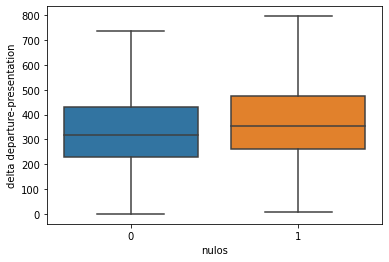

In [18]:
#Distribución de la variable respuesta en registros con y sin valores nulos en "location of the event"
df['nulos'] = np.where(df['location of the event'].isna(),1,0)

sns.boxplot(x = 'nulos' , y = 'delta departure-presentation', data = df,showfliers=False)

**¿Podemos imputar valores con el conocimiento que tenemos de los demás registros?**

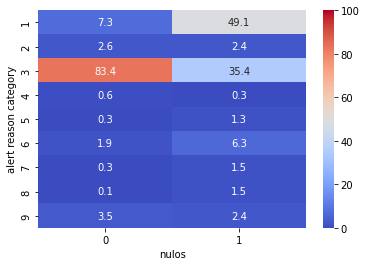

In [19]:
tabla = pd.crosstab(df['alert reason category'],df['nulos'], normalize = 'columns')*100

sns.heatmap(tabla,  vmin = 0, vmax = 100, cmap = "coolwarm", annot = True,
            fmt=".1f")

In [20]:
dict_alert_location = df.groupby('alert reason category')['location of the event'].agg(pd.Series.mode).to_dict()
dict_alert_location 

{1: 131.0,
 2: 149.0,
 3: 139.0,
 4: 139.0,
 5: 148.0,
 6: 148.0,
 7: 148.0,
 8: 131.0,
 9: 139.0}

In [22]:
# remplazamos los valores nulos en 'location of the event' de acuerdo al valor que presenta

df['location of the event'] = df['location of the event'].fillna( df['alert reason category'].map(dict_alert_location)).astype('object')
df['location of the event'].isna().sum()

0

In [28]:
df['location of the event'].value_counts(dropna=False)/len(df)*100

139.0    25.469027
136.0    20.242823
148.0    15.111450
149.0     4.654026
131.0     4.357222
           ...    
247.0     0.000456
248.0     0.000456
284.0     0.000456
265.0     0.000456
324.0     0.000456
Name: location of the event, Length: 210, dtype: float64

In [23]:
df = df.drop('nulos', axis=1)


# Transformación de variables

###  Creación de variable Rush Hour

Variable binaria para identificar eventos en horas pico

In [45]:
df['rush hour'] = 0

df = df.reset_index( )
df = df.set_index('selection time')

#identificar el indice de los registros de eventos en hora pico
pico_am = df.index.indexer_between_time('6:30','9:30')
pico_pm = df.index.indexer_between_time('16:00','19:00')
horas_pico_index= np.concatenate((pico_am, pico_pm))

#identificar los días sabados y domingos
fin_de_semana_filtro = df.index.weekday > 5  #identifica sábados y domingos

In [46]:
pico_am

array([     1,      6,      7, ..., 219307, 219308, 219310])

In [47]:
#comprobar que uno de los indices es hora pico
df.index.to_list()[1]  

Timestamp('2018-01-04 09:02:59.470000')

In [48]:
df = df.reset_index()

# cambiar el valor de 'rush hour' a uno cuando sea horas pico
df.iloc[list(horas_pico_index),-1] = 1  

In [49]:
#Regresar a 0 el valor para los días sabados y domingos
df['rush hour']= np.where(fin_de_semana_filtro, 0, df['rush hour'])

### Creación de variable Weekday
Variable binaria para identificar eventos de lunes a viernes

In [50]:
df['weekday'] = np.where(fin_de_semana_filtro, 0, 1)

In [51]:
#Regresar emerency vehicle selection como indice
df = df.set_index('emergency vehicle selection')

# Exploración de variables categoricas

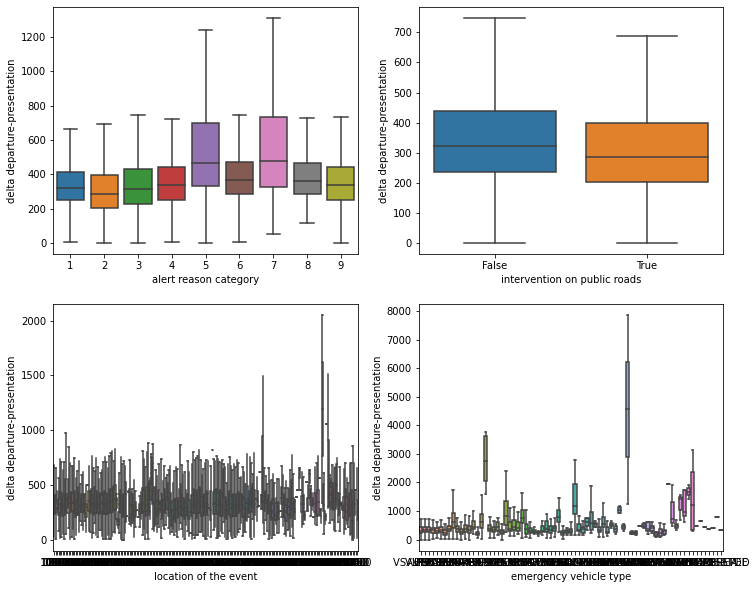

In [52]:
cat = df.select_dtypes(include=['object', 'bool'])
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for var, subplot in zip(cat.columns, ax.flatten()):
    sns.boxplot(x = var , y = 'delta departure-presentation', data = df,
                ax=subplot, showfliers=False )

In [53]:
df.describe(include='object')

,alert reason category,location of the event,emergency vehicle type
count,219337,206627.0,219337
unique,9,210.0,75
top,3,139.0,VSAV BSPP
freq,176787,51031.0,159620


### Identificación de principales categorías: `location of the event`
Explorar la distribución de 'location of the event' y notar que 8 categorías concentran más de 75% de los datos

In [65]:
df['location of the event'].value_counts(normalize=True, dropna=False).cumsum().head(8)

139.0    0.254690
136.0    0.457118
148.0    0.608233
149.0    0.654773
131.0    0.698345
140.0    0.722222
107.0    0.744421
137.0    0.765753
Name: location of the event, dtype: float64

In [66]:
#remplazar por 'other' todos los valores no contenidos en la lista locations_fr
locations_fr = list(df['location of the event'].value_counts(normalize=True).cumsum().head(8).index)
df.loc[~df['location of the event'].isin(locations_fr),'location of the event'] = np.nan
df['location of the event'].value_counts(normalize=True, dropna=False)

139.0    0.254690
NaN      0.234247
136.0    0.202428
148.0    0.151114
149.0    0.046540
131.0    0.043572
140.0    0.023877
107.0    0.022199
137.0    0.021332
Name: location of the event, dtype: float64

### Identificación de principales categorías: `emergency vehicle type`
Explorar la distribución de 'emergency vehicle type' y notar que 3 elementos concentran más del 90% de los datos

In [67]:
df['emergency vehicle type'].value_counts(normalize=False)

VSAV BSPP       159620
PSE              32927
VLR BSPP          5820
FPT BSPP          4107
AR                2583
                 ...  
VELD                 1
SP BALLON            1
VIRB                 1
UMH DEBREPED         1
DAP                  1
Name: emergency vehicle type, Length: 75, dtype: int64

In [68]:
df['emergency vehicle type'].value_counts(normalize=True).cumsum().head(3)

VSAV BSPP    0.727739
PSE          0.877859
VLR BSPP     0.904394
Name: emergency vehicle type, dtype: float64

In [69]:
#remplazar por 'other' todos los valores no contenidos en la lista vehiculos_fr
vehiculos_fr= list(df['emergency vehicle type'].value_counts(normalize=True).cumsum().head(3).index)
df.loc[~df['emergency vehicle type'].isin(vehiculos_fr),'emergency vehicle type'] =np.nan
df['emergency vehicle type'].value_counts(normalize=True, dropna=False)

VSAV BSPP    0.727739
PSE          0.150121
NaN          0.095606
VLR BSPP     0.026535
Name: emergency vehicle type, dtype: float64

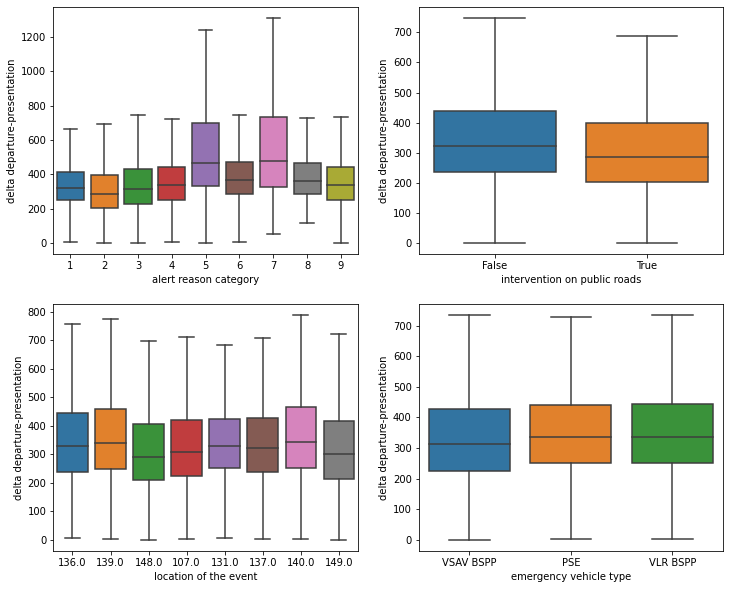

In [70]:
cat = df.select_dtypes(include=['object', 'bool'])
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
for var, subplot in zip(cat.columns, ax.flatten()):
    sns.boxplot(x = var , y = 'delta departure-presentation', data = df,
                ax=subplot, showfliers=False )

## Hot encoding variables categoricas

In [71]:
c1 =pd.get_dummies(df['alert reason category'],
                   drop_first=True, prefix='alert_reason catogory') 
print(c1.shape)
c1.head()

(219337, 8)


,alert_reason catogory_2,alert_reason catogory_3,alert_reason catogory_4,alert_reason catogory_5,alert_reason catogory_6,alert_reason catogory_7,alert_reason catogory_8,alert_reason catogory_9
emergency vehicle selection,,,,,,,,
5105452,0,1,0,0,0,0,0,0
4720915,0,1,0,0,0,0,0,0
5365374,0,1,0,0,0,0,0,0
4741586,0,1,0,0,0,0,0,0
5381209,0,1,0,0,0,0,0,0


In [72]:
c2 = pd.get_dummies(df[['location of the event','emergency vehicle type']],
                   ) 
print(c2.shape)
c2.head()

(219337, 11)


,location of the event_107.0,location of the event_131.0,location of the event_136.0,location of the event_137.0,location of the event_139.0,location of the event_140.0,location of the event_148.0,location of the event_149.0,emergency vehicle type_PSE,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
emergency vehicle selection,,,,,,,,,,,
5105452,0,0,0,0,0,0,1,0,0,0,1
4720915,0,0,1,0,0,0,0,0,1,0,0
5365374,0,0,0,0,1,0,0,0,0,0,1
4741586,0,0,1,0,0,0,0,0,0,0,1
5381209,0,0,0,0,0,0,0,0,0,0,1


In [73]:
df=df.drop(columns=categoricas)
df=pd.concat([df, c1, c2], axis=1)
df.shape

(219337, 27)

In [74]:
#Llevar la etiqueta hasta la ultima posición 
cols = df.columns.tolist()
df = df[[c for c in df if c != 'delta departure-presentation'] + ['delta departure-presentation']]
print(df.shape)
df.info()

(219337, 27)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 219337 entries, 5105452 to 4868867
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   selection time                    219337 non-null  datetime64[ns]
 1   intervention on public roads      219337 non-null  bool          
 2   floor                             219337 non-null  int64         
 3   OSRM estimated distance           219337 non-null  float64       
 4   OSRM estimated duration           219337 non-null  float64       
 5   rush hour                         219337 non-null  int64         
 6   weekday                           219337 non-null  int64         
 7   alert_reason catogory_2           219337 non-null  uint8         
 8   alert_reason catogory_3           219337 non-null  uint8         
 9   alert_reason catogory_4           219337 non-null  uint8         
 10  alert_reason

# Exploración de las variables numéricas

In [75]:
boleanas=[]
for col in df.columns:
  if df[col].nunique()==2:
    boleanas.append(col)
df[boleanas]=df[boleanas].astype('bool')

In [76]:
df[boleanas].describe()

,intervention on public roads,rush hour,weekday,alert_reason catogory_2,alert_reason catogory_3,alert_reason catogory_4,alert_reason catogory_5,alert_reason catogory_6,alert_reason catogory_7,alert_reason catogory_8,alert_reason catogory_9,location of the event_107.0,location of the event_131.0,location of the event_136.0,location of the event_137.0,location of the event_139.0,location of the event_140.0,location of the event_148.0,location of the event_149.0,emergency vehicle type_PSE,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
count,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337,219337
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
freq,187201,171426,189459,213632,176787,218116,218556,214523,218436,218960,211856,214468,209780,174937,214658,163474,214100,186192,209129,186410,213517,159620


In [77]:
numericas = list(df.select_dtypes(include=['int64', 'float64']).columns)
numericas

['floor',
 'OSRM estimated distance',
 'OSRM estimated duration',
 'delta departure-presentation']

In [ ]:
corr_matrix = correlacion(df, matrix = True, tamaño=(22,20))

## Borrar redundantes

In [ ]:
#Identificar variables redundantes 

# Triangulo superior de la matriz de correlación en números absolutos
triangulo_sup = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape),
                                                1).astype(np.bool))

# Encontrar las columnas donde la correlación es 1
borrar = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] >= .7)]
borrar

In [ ]:
df = df.drop('OSRM estimated duration', axis=1)



In [ ]:
numericas = list(df.select_dtypes(include=['int64', 'float64']).columns)

In [ ]:
df[numericas].describe()


In [ ]:
sns.pairplot(df[numericas])

# Exploración de Outliers

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for cond, subplot in zip((True, False), ax.flatten()):
  sns.boxplot(y=df['delta departure-presentation'], showfliers=cond, ax= subplot)

## Identificar "a ojo" *outliers*

In [ ]:
df['delta departure-presentation'].describe()

In [ ]:
df['delta departure-presentation'].quantile(.975)

In [ ]:
df['outlier'] = 0
filtro_out = df['delta departure-presentation'] > df['delta departure-presentation'].quantile(.975)
df.loc[filtro_out,'outlier'] = 1

In [ ]:
df['outlier'].value_counts()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for dat, subplot in zip((df, df[-filtro_out], df[filtro_out]), ax.flatten()):
  sns.histplot(x='delta departure-presentation', hue='outlier', 
               data=dat, ax=subplot )
plt.show()

In [ ]:
seleccion = ((df['OSRM estimated distance']>20350) & (df['OSRM estimated distance']<20500))
df[seleccion].head()

# Comparación Regresión lineal, Regresión robusta

In [ ]:
Z = df['delta departure-presentation']
X = df.drop(['selection time', 'delta departure-presentation', 'outlier'],
            axis=1)

X_train, X_test, Z_train, Z_test = train_test_split(X, Z, 
                                                    test_size=0.3, 
                                                    shuffle=True,
                                                    random_state=261)

# Guardamos datos preprocesados

In [ ]:
df_preprocesado = pd.concat([X,Z], axis=1)
#comprobamos dimensiones
X.shape,    Z.shape,   df_preprocesado.shape

In [ ]:
#df_preprocesado.to_csv('/content/drive/MyDrive/Datos/ParisFireBrigade/Output/df_selec.csv')

In [ ]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", Z_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", Z_test.shape)

## Regresión Lineal

In [ ]:
lr = LinearRegression().fit(X_train, Z_train)

Z_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(Z_test - Z_pred ))
error_medio_absoluto

In [ ]:
metrics.mean_absolute_error(Z_test, Z_pred)

In [ ]:
lr.coef_

In [ ]:
lr.intercept_

In [ ]:
#calculamos los errores
errores = (np.array(Z_test) - Z_pred)
len(errores)

In [ ]:
#una de las hipotesis de la regresión es que los errores son
#independientes  entre sí, teniendo una distribución normal

media = np.mean(Z_test - Z_pred)           
des_est = np.sqrt(np.var(Z_test - Z_pred))

media,des_est

### Comparación de los errores empirícos con una la distribución normal

In [ ]:
# Comparación de la distribución teórica(normal) y empirica de los errores

# Se elige una submuestra (%0.5) con el propósito de obtener una mejor visualización
errores_empiricos = np.random.choice(errores, 660)

# Se obtienen 329 valores a partir de la distribución normal (teorica) usando la media
# y la desviación de los errores
errores_teoricos = np.random.normal(media, des_est, 660)

# Comparamos las gráficas de ambas distribuciones

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, errores_empiricos), ax.flatten()):
  sns.histplot(x=dat, ax=subplot, kde=True, )
  
plt.show()

### Calculo de [$R^2$](https://docs.google.com/presentation/d/1k0aYwEBzaaAkWjX6jRKAc40nKHi3FROkJwtXCOE22mI/edit#slide=id.ga8926b2cd2_0_14) 

$MSE = \cfrac{1}{n}\sum{( y - y_{pred})}^2$

 $R^2 	= 1 -  \cfrac{MSE(modelo)}{MSE(linea~base)}$


In [ ]:
# Error cuadrado medio (MSE) linea base (promedio de las etiquetas)

errores_lb = Z_test - Z_test.mean()
MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
MSE_base

In [ ]:
#Error cuadrado medio (MSE) modelo
errores = Z_test - Z_pred

MSE_modelo = pow(errores,2).sum()/len(errores)
MSE_modelo

In [ ]:
R2 = 1 - MSE_modelo/MSE_base #¿cuánto mejora la predicción nuestro modelo?
R2

In [ ]:
R2 = 1 - MSE_base/MSE_base
R2

In [ ]:
def R_cuadrada(val_obs, val_pred):
  errores_lb = val_obs - val_obs.mean()
  errores_m = val_obs - val_pred
  MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
  MSE_modelo = pow(errores,2).sum()/len(errores)
  R2 = 1 - MSE_modelo/MSE_base
  return R2

In [ ]:
R_cuadrada(Z_test, Z_pred)

In [ ]:
metrics.r2_score(Z_test, Z_pred)

## Regresión Robusta

In [ ]:
hr = HuberRegressor( epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False, 
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, Z_train)
Z_pred = hr.predict(X_test)

print(metrics.mean_absolute_error(Z_test, Z_pred))
print('MAE:', metrics.mean_absolute_error(Z_test, Z_pred))

In [ ]:
hr.coef_

In [ ]:
coeficientes_hr = pd.DataFrame({'coef':hr.coef_, 'variable':list(X.columns)})
coeficientes_hr.sort_values('coef').reset_index(drop=True)

# Estandarizar valores para comparar importancia de variables

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_estandarizados=X.copy()
columnas = X.columns

scaler = StandardScaler()

X_estandarizados[columnas] = scaler.fit_transform(X[columnas])

In [ ]:

X_train, X_test, Z_train, Z_test = train_test_split(X_estandarizados, Z, test_size=0.3, 
                                                    shuffle=True, random_state=261)

In [ ]:
hr_st = HuberRegressor( epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False, 
                    fit_intercept=True, tol=1e-05)
hr_st = hr.fit(X_train, Z_train)

In [ ]:
coeficientes_hr_st = pd.DataFrame({'coef':hr_st.coef_, 'variable':list(columnas)})
coeficientes_hr_st.sort_values('coef').reset_index(drop=True)